In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from py.split_df import split_df
from py.simulate import simulate
from py.portfolio import Portfolio

In [14]:
# Variables

assets = ['ETH', 'USD']

# We'll use 180 day windows (6 months) with 120 day overlap (4 months)
# Since our dataframe is in hours, multiply by 24
window_len = 24 * 180
overlap = 24 * 120

allocation = {
    'bull': [0.90, 0.10],
    'neutral': [0.50, 0.50],
    'bear': [0.10, 0.90]
}

wiggle_room = 0.10

volatility_eth = []
volatility_fart = []
drawdown_eth = []
drawdown_fart = []
end_pct_eth = []
end_pct_fart = []
loss_probability_eth = []
loss_probability_fart = []

df_signals = pd.read_csv('backtests/signals.csv').to_dict(orient='records')

In [15]:
# Helper functions

def calc_volatility(array):
    # Determine 30-day volatility
    # Since we're using hourly data, 24*30 = 720 hours or 30 days

    volatility_lst = []
    
    for i in range(0, len(array), 720):
        volatility = (max(array[i:i+720]) - min(array[i:i+720])) / min(array[i:i+720])
        volatility_lst.append(volatility)
        
    return np.mean(volatility_lst)*100
    

def calc_drawdown(array):
    # At each price, compare the highest past price with the lowest future price
    # to determine the max potential drawdown
    
    drawdown = 0

    for i in range(1, len(array)):
        prev_max = max(array[:i])
        future_min = min(array[i:])

        max_potential_drawdown = (prev_max - future_min) / prev_max

        if max_potential_drawdown > drawdown:
            drawdown = max_potential_drawdown

    return drawdown*100


def calc_end_pct(array):
    # Return % change between start and finish
    
    end_pct = (array[-1] - array[0]) / array[0]
    return end_pct*100


def calc_loss_probability(array):
    # Count how many times our array is worth less than the starting value
    
    loss_count = sum(np.less(array, array[0]))
    loss_probability = loss_count / len(array)
    return loss_probability*100

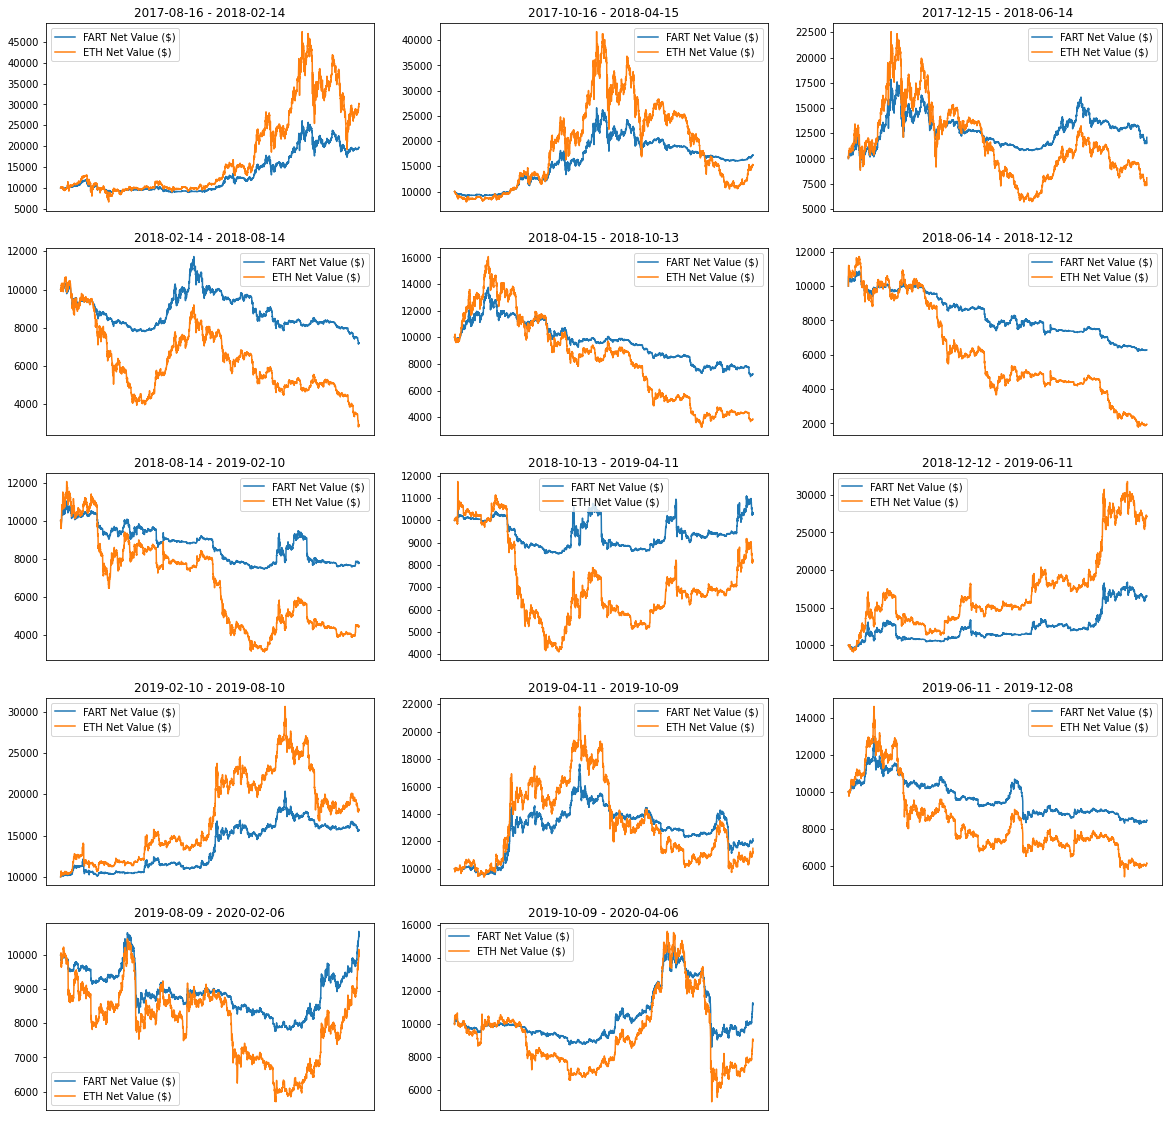

In [16]:
# Display charts

fig = plt.figure(figsize=(20, 20))


for i, df in enumerate(split_df(df_signals, overlap, window_len)):

    fart, eth, _ = simulate(assets, allocation, wiggle_room, df)

    # Append calculations
    volatility_eth.append(calc_volatility(eth))
    volatility_fart.append(calc_volatility(fart))
    
    drawdown_eth.append(calc_drawdown(eth))
    drawdown_fart.append(calc_drawdown(fart))

    end_pct_eth.append(calc_end_pct(eth))
    end_pct_fart.append(calc_end_pct(fart))

    loss_probability_eth.append(calc_loss_probability(eth))
    loss_probability_fart.append(calc_loss_probability(fart))
    

    df_plot = pd.DataFrame({'FART Net Value ($)': fart, 'ETH Net Value ($)': eth})

    ax = fig.add_subplot(5, 3, i+1)
    ax.plot(df_plot)
    ax.legend(df_plot.columns, loc='best')

    start, end = df[0]['date'][:df[0]['date'].find(' ')], df[-1]['date'][:df[-1]['date'].find(' ')]
    ax.set_title(f"{start} - {end}")
    ax.set_xticks([])

    
plt.show()

In [19]:
# Summary

df_volatility = pd.DataFrame({'ETH': volatility_eth, 'FART': volatility_fart})
print(f'Average Volatility % over 30 days: \n{round(df_volatility.mean(), 2)}\n')

df_drawdown = pd.DataFrame({'ETH': drawdown_eth, 'FART': drawdown_fart})
print(f'Absolute Max Drawdown % over 6 months: \n{df_drawdown.max()}\n')
print(f'Average Max Drawdown % over 6 months: \n{round(df_drawdown.mean(), 2)}\n')

df_end_pct = pd.DataFrame({'ETH': end_pct_eth, 'FART': end_pct_fart})
print(f'Average End Profit % over 6 months: \n{round(df_end_pct.mean(), 2)}\n')

df_loss_pct = pd.DataFrame({'ETH': loss_pct_eth, 'FART': loss_pct_fart})
print(f'Average % chance of selling at a loss over 6 months: \n{round(df_loss_pct.mean(), 2)}\n')

Average Volatility % over 30 days: 
ETH     62.83
FART    24.82
dtype: float64

Absolute Max Drawdown % over 6 months: 
ETH     84.680194
FART    48.774787
dtype: float64

Average Max Drawdown % over 6 months: 
ETH     64.06
FART    34.47
dtype: float64

Average End Profit % over 6 months: 
ETH     11.96
FART    16.13
dtype: float64

Average % chance of selling at a loss over 6 months: 
ETH     54.40
FART    49.98
dtype: float64

